## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 3: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

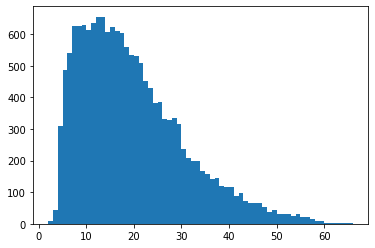

In [11]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [12]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen)
  return padded

In [14]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [15]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [16]:
classes = set(labels)
print(classes)

{'surprise', 'anger', 'joy', 'sadness', 'fear', 'love'}


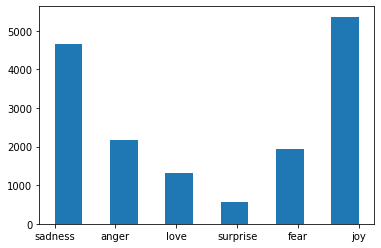

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [19]:
class_to_index

{'anger': 1, 'fear': 4, 'joy': 2, 'love': 5, 'sadness': 3, 'surprise': 0}

In [20]:
index_to_class

{0: 'surprise', 1: 'anger', 2: 'joy', 3: 'sadness', 4: 'fear', 5: 'love'}

In [21]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Task 6: Creating the Model

1. Creating the model
2. Compiling the model

In [23]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

## Task 7: Training the Model

1. Preparing a validation set
2. Training the model

In [24]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [26]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data =(val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 15s 18ms/step - loss: 1.3076 - accuracy: 0.4718 - val_loss: 0.7972 - val_accuracy: 0.7145
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.5496 - accuracy: 0.8062 - val_loss: 0.5469 - val_accuracy: 0.8160
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3225 - accuracy: 0.8919 - val_loss: 0.4734 - val_accuracy: 0.8465
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2233 - accuracy: 0.9289 - val_loss: 0.4884 - val_accuracy: 0.8475
Epoch 5/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1829 - accuracy: 0.9434 - val_loss: 0.4346 - val_accuracy: 0.8705
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1327 - accuracy: 0.9578 - val_loss: 0.4273 - val_accuracy: 0.8680
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1180 - accuracy: 0.9621 - val_loss: 0.4556 - val_accuracy: 0.872

## Task 8: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

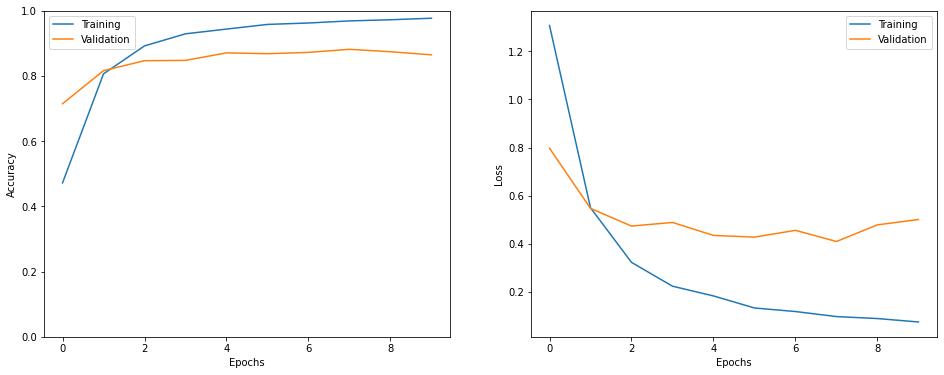

In [27]:
show_history(h)

In [28]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4888 - accuracy: 0.8690


In [30]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i honestly feel extremely shy to ask my friends to take pictures of me how vain must they think i am
Emotion: fear
Predicted Emotion: fear


In [31]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


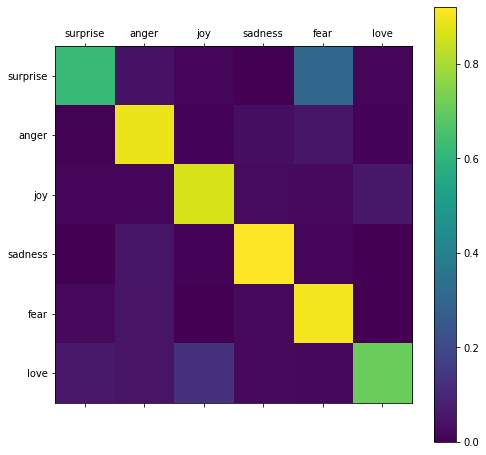

In [32]:
show_confusion_matrix(test_labels, preds, list(classes))